In [3]:
include("..\\Code_jail\\Master_func.jl")
using JLD

## Fourrier transform for small $k$ (Cheb)
Let's say we approximated $g₀$ using Chebyshev polynomials $T$. Note then that the Fourrier transform can be acchieved through two ways. We could use the three-term reccurence:
$$
b_{j+1}T_{j+1} = (a_j-x)T_j + b_jT_{j-1} ⇒ b_{j+1}\hat{T}_{j+1} = a_j\hat{T}_j-\partial_k\hat{T}_j + b_j\hat{T}_{j-1}.
$$
We can get $\partial_k\hat{T}_j$, through deriving the three-term recurrence for $\hat{T}_j$
$$ 
b_{j}\partial_k\hat{T}_j = a_{j-1}\partial_k\hat{T}_{j-1}-i\partial_{kk}\hat{T}_{j-1} + b_{j-1}\partial_k\hat{T}_{j-2}.
$$
We can go back to $\hat{T}_{0}$ and get all the derivatives. through the three-term recurrence. Luckely,
$$
\hat{T}_{0} = \int_{-1}^1e^{-ikx}\mathrm{d}x = 2\text{sinc}(k) = -2\int_0^1\cos(xk)\mathrm{d}x.
$$
Using this, we stabily compute the $n$th derivative,
$$
\hat{T}^{(n)}_{0} = -2\int_0^1x^n\cos\left(xk+\frac{n\pi}{2}\right)\mathrm{d}x.
$$
Using the three-term recurrence like this is stable for small $k$. It can quickly grow unstable when $k$ grows. Using this approximation as a substitute for the Fourrier transformed function will be nice.

This is too time expensive, even more than just doing the normal quadrature.

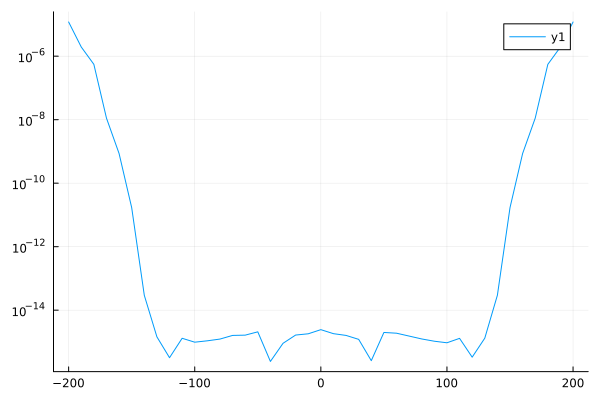

In [4]:
a = 1; f_ft = x -> (1im*((x-a)*sin(x+a)+(-x-a)*sin(x-a)))/(x^2-a^2)
λ = 0; N = 40;
f = UltraFun(λ,x -> sin(a*x),N-1);
dk = 10;
kk = -200:dk:200;
ff_ft = k -> (Cheb_ft(N,k,λ)[:,1,:]) * f.c ;
res_ff_ft = zeros(size(kk)) .* 1im;
for i1 = 1:length(kk)
    res_ff_ft[i1] = ff_ft(kk[i1])[1]
end
plot(kk,abs.(res_ff_ft-f_ft.(kk)), yaxis=:log)

## Fourrier transform for large $k$ (IBP)
What if we integrate the Fourrier transform by parts. We get
$$
\mathcal{F}(T)[k]=\int_{-1}^1 e^{-ikx}T(x)\mathrm{d}x = \sum_{j=0}^N (-1)^{j}\left(\frac{i}{k}\right)^{j+1}\left[T^{(j)}(x)e^{-ikx}\right]_{-1}^1 + (-1)^{N+1}\left(\frac{i}{k}\right)^{N+1}\int_{-1}^1T^{(N+1)}(x)e^{-ikx}\mathrm{d}x.
$$

In [5]:
function IBP_ft(f,k,Nd)
    
    # Ultrafun f
    
    # Frequency k
    
    # Number of Chebychev polynomials N
    
    # Number of Derivatives Nd
    
    g = x-> exp.(-1im .* k .* x);
    res = k .* 0
    for i1 = 0:Nd
        res += (-1. * 1im)^(i1-1) .* (g(1) * f(1) - g(-1) * f(-1)) ./ ((k) .^ (i1+1))
        f = Diff(f)
    end
    s = curv(x->x,-1,1,x->1,200)
    res += (-1im)^(Nd+1) .* Clen_Curt(x -> f.(x) .* g.(x),s) ./ ((k) .^ (Nd+1))
   return res 
    
end

IBP_ft (generic function with 1 method)

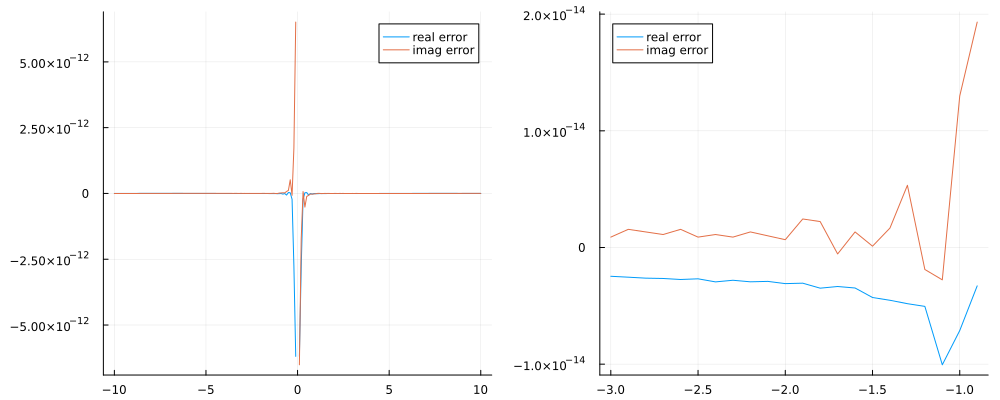

In [6]:
a = pi; f = UltraFun(0,x -> sin(a*x),100); f_ft = x -> (1im*((x-a)*sin(x+a)+(-x-a)*sin(x-a)))/(x^2-a^2)

kk = -10:0.1:10
ff_ft = k -> IBP_ft(f,k,3)
plot(layout = grid(1, 2),size=(1000,400));
plot!(kk,real.(f_ft.(kk)).-real.(ff_ft.(kk)), label ="real error", subplot = 1)
plot!(kk,imag.(f_ft.(kk)).-imag.(ff_ft.(kk)), label ="imag error", subplot = 1)
kk = -3:0.1:-0.9
plot!(kk,real.(f_ft.(kk)).-real.(ff_ft.(kk)), label ="real error", subplot = 2)
plot!(kk,imag.(f_ft.(kk)).-imag.(ff_ft.(kk)), label ="imag error", subplot = 2)

## Fourier scaling
Using a Chebyshev approximation, we can thus get the Fourier transform. However, Most functions don't have the domain $[-1,1]$. Assume we have a function $g:[0,L]\to\mathbb{R}$, the question is: How can we obtain the Fourrier approximation, using what we found above. At this moment we compute the Fourier transform of
$$
\tilde{g}(x) = g(φ^{-1}(x)), \text{ with }\tilde{g}:[-1,1]\to\mathbb{R}\text{ and } φ^{-1}:[-1,1]\to[0,L]: x ↦ \frac{L}{2}(x+1),
$$
where $\tilde{g}$ can be assumed to be a function approximated by Polynomials.Note that this can be remapped to
$$
g = \tilde{g}(φ(x)), \text{ with }\tilde{g}:[-1,1]\to\mathbb{R}\text{ and } φ:[0,L]\to[-1,1]: x ↦ \frac{2}{L}x-1.
$$
We know $\mathcal{F}(\tilde{g})[k]$, so let's get $\mathcal{F}(g)[k]$.
\begin{align*}
\mathcal{F}(g)[k] &= \int_0^L e^{-ikx}g(x)\mathrm{d}x = \sum_jc_j \int_0^L e^{-ikx}T_j(φ(x))\mathrm{d}x = \frac{L}{2}\sum_jc_j \int_{-1}^1 e^{-ik(x+1)\frac{L}{2}}T_j(x)\mathrm{d}x \\
&= \frac{L}{2}e^{-ik\frac{L}{2}}\sum_jc_j \int_{-1}^1 e^{-ik\frac{L}{2}x}T_j(x)\mathrm{d}x\\
&= \frac{L}{2}e^{-ik\frac{L}{2}}\left(\sum_jc_j \mathcal{F}(T_j)\right)\left[\frac{L}{2}k\right] \\
&=  \frac{L}{2}e^{-ik\frac{L}{2}} \mathcal{F}(\tilde{g})\left[\frac{L}{2}k\right]\\
&= -\sum_{j=0}^N (\frac{2}{L})^{j}\left(\frac{1}{ik}\right)^{j+1}\left[\tilde{g}^{(j)}(x)e^{-i\frac{L}{2}k(x+1)}\right]_{-1}^1 + (\frac{2}{L})^{N}\left(\frac{1}{ik}\right)^{N+1}\int_{-1}^1\tilde{g}^{(N+1)}(x)e^{-i\frac{L}{2}k(x+1)}\mathrm{d}x
\end{align*}

In [7]:
function IBP_scaling(f,L,k,Nd)    
    g = x-> exp.(-1im .* k .* (x .+ 1) * L/2);
    res = k .* 0
    for i1 = 0:Nd
        res -= (2/L)^(i1) .* (g(1) * f(1) - g(-1) * f(-1)) ./ ((1im*k) .^ (i1+1))
        f = Diff(f)
    end
    s = curv(x->x,-1,1,x->1,200)
    res += (2/L)^Nd*(-1im ./ k)^(Nd+1) .* Clen_Curt(x -> f.(x) .* g.(x),s)
   return res 
    
end

IBP_scaling (generic function with 1 method)

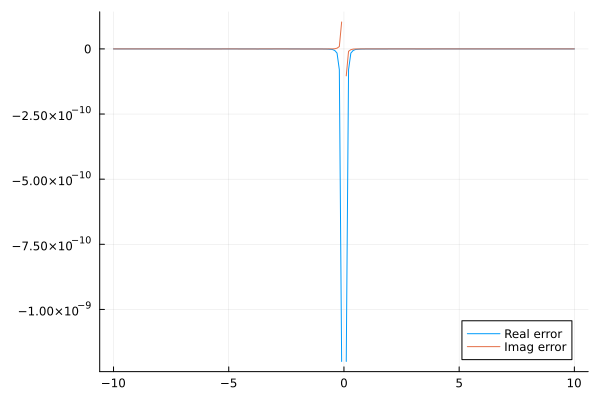

In [8]:
L = 4; a = pi;
φ = x -> (x+1)*L/2
a = pi; f = UltraFun(0,x -> sin(a*φ(x)),100); 
f_ft = k -> (-a + exp(-1im*k*L)*(a*cos(a*L) + 1im*k*sin(a*L)))/((-a + k)*(a + k))
ff_ft = k -> IBP_scaling(f,L,k,3) 
kk = -10:0.1:10

plot(kk,real.(f_ft.(kk)-ff_ft.(kk)),label="Real error")
plot!(kk,imag.(f_ft.(kk)-ff_ft.(kk)),label="Imag error")

In [9]:
function Fourier_scaling(f_ft,L)
    k -> L/2 .* exp.(-1im .* k .* (L/2)) .* f_ft.(k.* (L/2))
end

Fourier_scaling (generic function with 1 method)

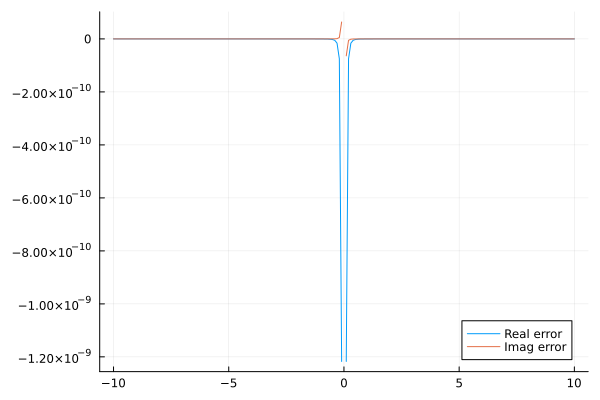

In [10]:
L = 4; a = pi;
φ = x -> (x+1)*L/2
a = pi; f = UltraFun(0,x -> sin(a*φ(x)),100); 
f_ft = x -> (-a + exp(-1im*x*L)*(a*cos(a*L) + 1im*x*sin(a*L)))/((-a + x)*(a + x))
ff_ft = Fourier_scaling(k -> IBP_ft(f,k,3),L)
plot(kk,real.(f_ft.(kk)-ff_ft.(kk)),label="Real error")
plot!(kk,imag.(f_ft.(kk)-ff_ft.(kk)),label="Imag error")

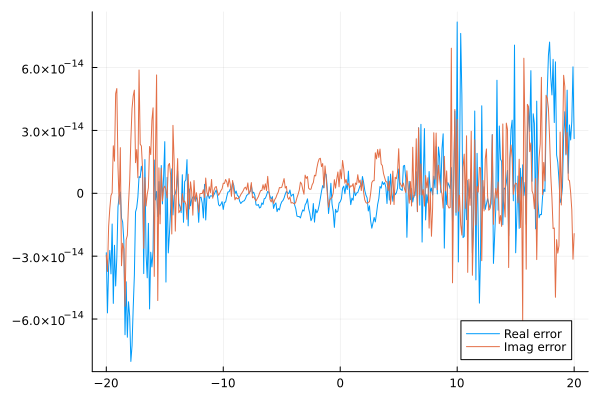

In [11]:
λ = 0; N = 40;
f = UltraFun(λ,x -> sin(a*φ(x)),N-1); 
ff_ft = Fourier_scaling(k -> (Cheb_ft(N,k,λ)[:,1,:]) * f.c ,L)
kk = -20:0.1:20
res_ff_ft = zeros(size(kk)) .* 1im;
for i1 = 1:length(kk)
    res_ff_ft[i1] = ff_ft(kk[i1])[1]
end
plot(kk,real.(f_ft.(kk)-res_ff_ft),label="Real error")
plot!(kk,imag.(f_ft.(kk)-res_ff_ft),label="Imag error")